In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from collections import Counter
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
import optuna

# Specify the path to the CSV file
file_path_train = "data/train.csv"
file_path_test = "data/test.csv"


# Read the CSV file into a DataFrame
df = pd.read_csv(
    file_path_train,
    delimiter=",",
    parse_dates=["host_since", "first_review", "last_review"],
)
df_test = pd.read_csv(
    file_path_test,
    delimiter=",",
    parse_dates=["host_since", "first_review", "last_review"],
)

# Drop the original price column and separate features and target
y = df["price"]
X = df.drop(columns=["price"])
ID_test = df_test["id"]
X_test = df_test.drop(columns=["id"])

In [2]:
# test to make sure you can download external model.
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=0,
)
# EX
review = "This house is terrible, do not go!"
result = classifier(review)
print(result)

[{'label': '1 star', 'score': 0.9736103415489197}]


For the next part you should uncomment these chunks of code if you do not have the files. They use nlptown/bert-base-multilingual-uncased-sentiment for feture engenering and then save it to a file. They take some time to run. So after the first time you should just read from the file. Which is currently uncommented

In [ ]:
# def process_batch_input(X_data, classifier):
#     # Processing 'name' column
#     batch_input = X_data[
#         "name"
#     ].tolist()  # Convert to list for batch processing
#     results = classifier(batch_input)  # Perform batch classification
#     X_data["name_pred"] = [
#         res["label"] for res in results
#     ]  # Assuming each result is a list of predictions
#     X_data["name_score"] = [
#         res["score"] for res in results
#     ]  # Adjust if classifier returns more

#     # Processing 'description' column
#     X_data["description"] = X_data["description"].astype(
#         str
#     )  # Ensure all are strings
#     batch_input = X_data[
#         "description"
#     ].tolist()  # Convert to list for batch processing
#     results = classifier(batch_input)  # Perform batch classification
#     X_data["description_pred"] = [
#         res["label"] for res in results
#     ]  # Assuming each result is a list of predictions
#     X_data["description_score"] = [
#         res["score"] for res in results
#     ]  # Adjust if classifier returns more

#     return X_data


# # Usage
# X = process_batch_input(X, classifier)
# X_test = process_batch_input(X_test, classifier)
# # Save predictions and scores for X
# X[["name_pred", "name_score", "description_pred", "description_score"]].to_csv(
#     "data/my_data/X_description_predictions.csv", index=False
# )
# # Save predictions and scores for X_test
# X_test[
#     ["name_pred", "name_score", "description_pred", "description_score"]
# ].to_csv("data/my_data/X_test_description_predictions.csv", index=False)

In [ ]:
# # Helper function to extract star level and create new columns
# def add_star_scores(df, col_pred, col_score, prefix):
#     for star in range(1, 6):  # Loop over star levels 1 to 5
#         star_label = f"{star} stars"
#         df[f"{prefix}_{star}"] = df.apply(
#             lambda row: row[col_score] if row[col_pred] == star_label else 0,
#             axis=1,
#         )
#     return df


# # Read the prediction files
# X_preds = pd.read_csv("data/my_data/X_description_predictions.csv")
# X_test_preds = pd.read_csv("data/my_data/X_test_description_predictions.csv")

# # Transform data for name and description
# X_preds = add_star_scores(X_preds, "name_pred", "name_score", "name")
# X_preds = add_star_scores(
#     X_preds, "description_pred", "description_score", "description"
# )
# # Drop original prediction columns
# X_preds = X_preds.drop(
#     columns=[
#         "name_pred",
#         "name_score",
#         "description_pred",
#         "description_score",
#     ]
# )

# # Transform data for name and description
# X_test_preds = add_star_scores(X_test_preds, "name_pred", "name_score", "name")
# X_test_preds = add_star_scores(
#     X_test_preds, "description_pred", "description_score", "description"
# )
# # Drop original prediction columns
# X_test_preds = X_test_preds.drop(
#     columns=[
#         "name_pred",
#         "name_score",
#         "description_pred",
#         "description_score",
#     ]
# )

# # Concatenate the predictions with X and X_test on axis 1 (column-wise)
# X = pd.concat([X, X_preds], axis=1)
# X_test = pd.concat([X_test, X_test_preds], axis=1)

In [ ]:
# from datasets import Dataset
# import math
# from collections import defaultdict

# # Define candidate labels


# # Function to classify multiple reviews for a single property
# def classify_property_reviews(
#     reviews_text, separator="---------------------------------"
# ):
#     # Split concatenated reviews
#     reviews = ""
#     if pd.isna(reviews_text):
#         # print(reviews_text)
#         reviews = ["netrual"]
#     else:
#         # print(reviews_text)
#         reviews = reviews_text.split(separator)
#         # Classify reviews in batch using the pipeline
#         reviews = reviews_text.split(separator)
#         reviews = [
#             review.strip() for review in reviews if review.strip()
#         ]  # Make sure each review is a clean, non-empty string

#     # Classify reviews in batch using the pipeline
#     results = []
#     for review in reviews:
#         if len(review) >= 512:
#             review = review[0:510]
#         result = classifier(review)
#         results.append(result)

#     # Step 1: Aggregate labels and scores
#     aggregated_results = defaultdict(list)

#     # Loop through the results and store the label and score
#     for result in results:
#         for entry in result:
#             label = entry["label"]
#             score = entry["score"]
#             aggregated_results[label].append(score)

#     # Step 2: Calculate the average score for each label
#     final_results = {
#         label: {
#             "count": len(scores),
#             "average_score": sum(scores) / len(scores),
#         }
#         for label, scores in aggregated_results.items()
#     }
#     return final_results


# # Convert X_test to Hugging Face Dataset format
# # Assuming X_test is your original pandas DataFrame

# # Apply the classification function to each review in a batch

# # Apply the classification function to each review
# results = []
# total_reviews = len(X["reviews"])  # Get the total number of reviews

# for i, review in enumerate(X["reviews"]):
#     # Perform the classification
#     results.append(classify_property_reviews(review))

#     # Print progress every 25 reviews as a percentage of the total
#     if (i + 1) % 25 == 0:
#         progress = (i + 1) / total_reviews * 100
#         print(
#             f"Processed {i + 1} reviews out of {total_reviews} ({progress:.2f}%)"
#         )


# df_rows = []
# for entry in results:
#     row = {}
#     for star, values in entry.items():
#         row[f"{star}_count"] = values["count"]
#         row[f"{star}_average_score"] = values["average_score"]
#     df_rows.append(row)

# # Create a DataFrame from the rows
# df_rev = pd.DataFrame(df_rows)
# # Write the DataFrame to a CSV file
# df_rev.to_csv(
#     "data/my_data/classified_reviews_X.csv", index=False
# )  # index=False to avoid writing row indices
# print(
#     "DataFrame written to 'src/main_workspace/Final_Project/data/my_data/classified_reviews.csv'"
# )

In [6]:
# Read the CSV file back into a DataFrame
df_x_test_reviews = pd.read_csv("data/my_data/classified_reviews_X_test.csv")
df_X_reviews = pd.read_csv("data/my_data/classified_reviews_X.csv")

X_clean = X.copy()
X_test_clean = X_test.copy()

X_clean = pd.concat([X_clean, df_X_reviews], axis=1)
X_test_clean = pd.concat([X_test_clean, df_x_test_reviews], axis=1)

In [8]:
def get_top_amenities(list_of_lists, n=10):
    # Flatten the list of lists
    all_amenities = [item for sublist in list_of_lists for item in sublist]

    # Count occurrences of each amenity
    amenity_counts = Counter(all_amenities)

    # Get the top 10 most common amenities
    top_n_amenities = amenity_counts.most_common(n)

    # Extract just the amenity names
    top_amenity_names = [amenity for amenity, count in top_n_amenities]

    # Calculate the total number of amenities for each row
    total_amenities_per_row = [len(sublist) for sublist in list_of_lists]

    return top_amenity_names, total_amenities_per_row


# Convert the 'amenities' column from string format to a Python list
X["amenities"] = (
    X["amenities"]
    .str.replace("[", "")
    .str.replace("]", "")
    .str.replace('"', "")
    .str.split(", ")
)
X_test["amenities"] = (
    X_test["amenities"]
    .str.replace("[", "")
    .str.replace("]", "")
    .str.replace('"', "")
    .str.split(", ")
)
# Get top 3000 amenities
n = 3000
top_amenities, total_amenities_per_row = get_top_amenities(
    X["amenities"].to_numpy(), n
)
top_amenities_test, total_amenities_per_row_test = get_top_amenities(
    X_test["amenities"].to_numpy(), n
)

# Convert datetime columns for X
datetime_columns = ["host_since", "first_review", "last_review"]
for col in datetime_columns:
    X[col] = pd.to_datetime(X[col], errors="coerce")
    min_date = X[col].min()
    X[f"{col}_numeric"] = (X[col] - min_date).dt.days
    X[f"{col}_numeric"] = X[f"{col}_numeric"].replace({pd.NaT: np.nan})

# Convert datetime columns for X_test
for col in datetime_columns:
    X_test[col] = pd.to_datetime(X_test[col], errors="coerce")
    min_date = X_test[col].min()
    X_test[f"{col}_numeric"] = (X_test[col] - min_date).dt.days
    X_test[f"{col}_numeric"] = X_test[f"{col}_numeric"].replace(
        {pd.NaT: np.nan}
    )

In [9]:
print(df.index)

RangeIndex(start=0, stop=15696, step=1)


In [ ]:
# Print the type and first row value of each column is long ouptut
for col in df.columns:
    print(f"{col} (Type: {df[col].dtype}): {df[col].iloc[0]}")

name (Type: object): Bed-Stuy 2 Bed/2 Bath - Renovated
description (Type: object): Welcome to Bed-Stuy, Brooklyn! Our newly renovated brownstone has an apartment that is colorful and comfortable and entirely yours during your stay. Bed-Stuy is a friendly neighborhood with tree-lined streets and rows upon rows of traditional brownstones. We are close to many restaurants and coffee shops as well as perfectly located for exploring Brooklyn. Relax on the patio or take a quick trip into that other borough (Manhattan). We are a 5 minute walk to the Kingston/Throop C subway.
property_type (Type: object): Entire rental unit
price (Type: int64): 4
neighbourhood_cleansed (Type: object): Bedford-Stuyvesant
neighbourhood_group_cleansed (Type: object): Brooklyn
latitude (Type: float64): 40.68456
longitude (Type: float64): -73.93987
host_since (Type: datetime64[ns]): 2015-05-23 00:00:00
host_response_time (Type: object): within a day
host_response_rate (Type: float64): 100.0
host_acceptance_rate (Ty

In [11]:
# Separate numeric and other columns
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns
other_cols = X.select_dtypes(include=["object"]).columns

# Create one-hot encoded columns for the top amenities in a vectorized way
amenities_df = pd.DataFrame(
    {
        f'has_{amenity.lower().replace(" ", "_")}': X_clean["amenities"].apply(
            lambda x: int(amenity in x)
        )
        for amenity in top_amenities
    }
)

# Concatenate the new columns with the original DataFrame
X_clean = pd.concat([X_clean, amenities_df], axis=1)

X_clean = X_clean.drop(
    columns=[
        "name",
        "description",
        "reviews",
        "amenities",
        "bathrooms_text",
        "host_since",
        "first_review",
        "last_review",
    ]
)

# make new row for total_amenities
X_clean["total_amenities"] = total_amenities_per_row

# might remove neighbourhood_cleansed as it has a lot
cat_columns = [
    "property_type",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "host_verifications",
    "host_response_time",
    "room_type",
]
X_clean[cat_columns] = X_clean[cat_columns].astype("category")

# fix boolean data
X_clean["host_is_superhost"] = (
    X_clean["host_is_superhost"].fillna(False).astype(bool)
)
X_clean["has_availability"] = (
    X_clean["has_availability"].fillna(False).astype(bool)
)


# Scale only the numeric columns
# scaler = StandardScaler()
# X_clean[numeric_cols] = scaler.fit_transform(X_clean[numeric_cols])

# One-hot encode categorical columns
# X_clean = pd.get_dummies(X_clean, columns=cat_columns, drop_first=True)

# converting a categorical column to integer labels
for col in cat_columns:
    X_clean[col] = LabelEncoder().fit_transform(X_clean[col])
categorical_features = [X_clean.columns.get_loc(col) for col in cat_columns]


# Function to clean column names
def clean_column_name(col_name):
    return col_name.replace("[", "").replace("]", "").replace("<", "")


# Apply the cleaning function to all column names
X_clean.columns = X_clean.columns.map(clean_column_name)


# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y, test_size=0.2, random_state=42
)

/tmp/ipykernel_34206/3303425703.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['host_is_superhost'] = X_clean['host_is_superhost'].fillna(False).astype(bool)
/tmp/ipykernel_34206/3303425703.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_clean['has_availability'] = X_clean['has_availability'].fillna(False).astype(bool)


In [12]:
# Separate numeric and other columns for X_test
numeric_cols_test = X_test.select_dtypes(include=["float64", "int64"]).columns
other_cols_test = X_test.select_dtypes(include=["object"]).columns
# X_test_clean = X_test.copy()

# Create one-hot encoded columns for the top amenities in a vectorized way for X_test
amenities_df_test = pd.DataFrame(
    {
        f'has_{amenity.lower().replace(" ", "_")}': X_test_clean[
            "amenities"
        ].apply(lambda x: int(amenity in x))
        for amenity in top_amenities
    }
)

# Concatenate the new columns with the original DataFrame for X_test
X_test_clean = pd.concat([X_test_clean, amenities_df_test], axis=1)

X_test_clean = X_test_clean.drop(
    columns=[
        "name",
        "description",
        "reviews",
        "amenities",
        "bathrooms_text",
        "host_since",
        "first_review",
        "last_review",
    ]
)

# Make new row for total_amenities for X_test
X_test_clean["total_amenities"] = total_amenities_per_row_test

# might remove neighbourhood_cleansed as it has a lot of categories
cat_columns_test = [
    "property_type",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "host_verifications",
    "host_response_time",
    "room_type",
]
X_test_clean[cat_columns_test] = X_test_clean[cat_columns_test].astype(
    "category"
)

# Fix boolean data for X_test
X_test_clean["host_is_superhost"] = (
    X_test_clean["host_is_superhost"].fillna(False).astype(bool)
)
X_test_clean["has_availability"] = (
    X_test_clean["has_availability"].fillna(False).astype(bool)
)

# One-hot encode categorical columns if needed
# X_test_clean = pd.get_dummies(X_test_clean, columns=cat_columns_test, drop_first=True)

# Converting a categorical column to integer labels for X_test
for col in cat_columns_test:
    X_test_clean[col] = LabelEncoder().fit_transform(X_test_clean[col])
categorical_features_test = [
    X_test_clean.columns.get_loc(col) for col in cat_columns_test
]


# Function to clean column names for X_test
def clean_column_name(col_name):
    return col_name.replace("[", "").replace("]", "").replace("<", "")


# Apply the cleaning function to all column names in X_test
X_test_clean.columns = X_test_clean.columns.map(clean_column_name)

/tmp/ipykernel_34206/647170005.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_clean['host_is_superhost'] = X_test_clean['host_is_superhost'].fillna(False).astype(bool)
/tmp/ipykernel_34206/647170005.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_clean['has_availability'] = X_test_clean['has_availability'].fillna(False).astype(bool)


In [26]:
# # verify is long ouptu
# len(X_clean.columns)
# for col in X_clean.columns:
#     print(f"{col} (Type: {X_clean[col].dtype}): {X_clean[col].iloc[0]}")

In [14]:
# test as needed for problems
unique_categories = df["host_identity_verified"].unique()
# Verify the result
print(len(unique_categories))
print(unique_categories)

2
[ True False]


In [15]:
# test to make sure not object or time colmns left
object_columns = X_clean.select_dtypes(include=["object"]).columns
print("Columns of type 'object' in X_clean:")
for col in object_columns:
    print(col)
object_columns = X_clean.select_dtypes(include=["datetime"]).columns
print("Columns of type 'time' in X_clean:")
for col in object_columns:
    print(col)

Columns of type 'object' in X_clean:
Columns of type 'time' in X_clean:


Max Depth: 3, RMSE: 0.7860
Max Depth: 4, RMSE: 0.7636
Max Depth: 5, RMSE: 0.7546
Max Depth: 6, RMSE: 0.7427
Max Depth: 7, RMSE: 0.7401
Max Depth: 8, RMSE: 0.7403
Max Depth: 9, RMSE: 0.7425
Max Depth: 10, RMSE: 0.7495


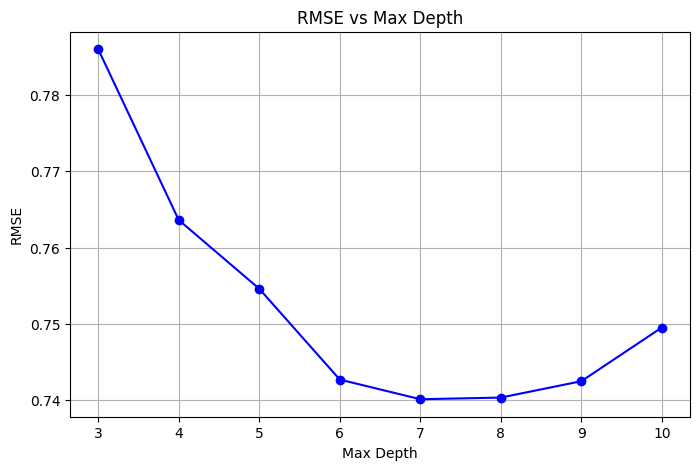

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Fixed parameters (from Best_Parameters)
fixed_params = {
    "learning_rate": 0.020534279384947673,
    "n_estimators": 1800,
    "subsample": 0.6817057463318822,
    "colsample_bytree": 0.7324724625794548,
    "reg_lambda": 0.2145407717059405,
    "reg_alpha": 0.7071638502266191,
    "min_child_weight": 1,
    "random_state": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

# Range of max_depth values to evaluate
max_depth_values = range(3, 11)  # Adjust the range as needed
rmse_values = []

# Iterate through max_depth values
for max_depth in max_depth_values:
    # Update max_depth in parameters
    params = {**fixed_params, "max_depth": max_depth}

    # Initialize and train the model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = y_pred_bounded = np.clip(np.round(model.predict(X_val)), 0, 5)

    # Compute RMSE and store it
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
    print(f"Max Depth: {max_depth}, RMSE: {rmse:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(max_depth_values, rmse_values, marker="o", linestyle="-", color="b")
plt.title("RMSE vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [17]:
# This takes a long time to run
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "early_stopping_rounds": 500,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "device": "cuda",
        "random_state": 1,
        # Hyperparameters to optimize
        "learning_rate": trial.suggest_float(
            "learning_rate", 1e-3, 2e-1, log=True
        ),
        "max_depth": trial.suggest_int(
            "max_depth", 8, 10
        ),  # Choose a reasonable range
        "n_estimators": trial.suggest_int(
            "n_estimators", 1200, 2000, step=100
        ),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
    }

    # param = {
    #     'objective': 'reg:squarederror',
    #     'eval_metric': 'rmse',
    #     'tree_method': 'hist',
    #     'device': 'cuda',
    #     'random_state': 1,
    #     'n_estimators': 100,
    #     'max_depth': 9,

    #     # Hyperparameters to optimize
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.09, log=True),
    #     #'max_depth': trial.suggest_int('max_depth', 8, 9),  # Near 9
    #   #  'n_estimators': trial.suggest_int('n_estimators', 50, 100, step=100),  # Around 1800
    #     'subsample': trial.suggest_float('subsample', 0.6, 0.9),  # Around 0.68
    #     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.8),  # Around 0.73
    #     'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1),  # Near 0.21
    #     'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.8),  # Around 0.71
    #     'min_child_weight': trial.suggest_int('min_child_weight', 1, 3),  # Slightly broader
    # }

    # Split the data into train/validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_clean, y, test_size=0.20, random_state=1
    )

    # Initialize the model
    model = xgb.XGBRegressor(**param)

    # Train the model with early stopping
    model.fit(
        X_train_split,
        y_train_split,
        eval_set=[
            (X_val_split, y_val_split)
        ],  # Stops if no improvement for 50 rounds
        verbose=False,
    )

    # Make predictions
    y_pred = np.clip(np.round(model.predict(X_val_split)), 0, 5)

    # Calculate RMSE as the optimization target
    rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
    return rmse  # Optuna minimizes the objective


# Optimize the objective
study = optuna.create_study(direction="minimize")
study.optimize(
    objective, n_trials=20
)  # Number of trials should be higher but I wnat to run this faster
print("Best Parameters:", study.best_params)

[I 2024-11-27 00:30:04,403] A new study created in memory with name: no-name-3961aaad-a13d-4f6d-bfef-17bcd728e01e
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-11-27 00:31:06,171] Trial 0 finished with value: 0.7507957561920043 and parameters: {'learning_rate': 0.01158502111449313, 'max_depth': 9, 'n_estimators': 1800, 'subsample': 0.7348718543522266, 'colsample_bytree': 0.7611075554408189, 'reg_lambda': 0.04004196747148958, 'reg_alpha': 0.7607854541522062, 'min_child_weight': 

Best Parameters: {'learning_rate': 0.02016142002232663, 'max_depth': 8, 'n_estimators': 1700, 'subsample': 0.7473793320100531, 'colsample_bytree': 0.7135410726626181, 'reg_lambda': 0.005433926484420647, 'reg_alpha': 0.13399520881395244, 'min_child_weight': 5}


Note that best Parameters will be diffrent for each run.

In [18]:
print("Best Parameters:", study.best_params)  # incase you want to stop early

Best Parameters: {'learning_rate': 0.02016142002232663, 'max_depth': 8, 'n_estimators': 1700, 'subsample': 0.7473793320100531, 'colsample_bytree': 0.7135410726626181, 'reg_lambda': 0.005433926484420647, 'reg_alpha': 0.13399520881395244, 'min_child_weight': 5}


In [19]:
# Step 1: Feature Selection
Best_Parameters = {
    "learning_rate": 0.020534279384947673,
    "max_depth": 7,
    "n_estimators": 1800,
    "subsample": 0.6817057463318822,
    "colsample_bytree": 0.7324724625794548,
    "reg_lambda": 0.2145407717059405,
    "reg_alpha": 0.7071638502266191,
    "min_child_weight": 1,
    "random_state": 1,
}
# Initialize the XGBRegressor with the specified parameters
model = xgb.XGBRegressor(**Best_Parameters)

# model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# Initialize and train XGBClassifier model chagne for valdation or test
# model.fit(X_clean, y) # test
model.fit(X_train, y_train)  # val

# Predictions on validation set
y_pred = y_pred_bounded = np.clip(np.round(model.predict(X_val)), 0, 5)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Root Mean Squared Error on validation set:", rmse)

# Predictions on training set
y_pred_train = np.clip(np.round(model.predict(X_train)), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error on training set:", train_rmse)

# Classification report on validation set
print("\nClassification Report on validation set:")
print(classification_report(y_val, y_pred))

# Feature importance (sorted)
importance = model.get_booster().get_score(importance_type="weight")
sorted_importance = sorted(
    importance.items(), key=lambda x: x[1], reverse=True
)
print("\nTop 10 Important Features:")
for feature, score in sorted_importance[:10]:  # Display top 10 features
    print(f"{feature}: {score}")

Accuracy on validation set: 0.6213375796178344
Root Mean Squared Error on validation set: 0.7401153292811483
Accuracy on training set: 0.9651
Root Mean Squared Error on training set: 0.18931307221605898

Classification Report on validation set:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       540
           1       0.59      0.55      0.57       524
           2       0.46      0.57      0.51       513
           3       0.51      0.62      0.56       556
           4       0.52      0.51      0.51       463
           5       0.89      0.71      0.79       544

    accuracy                           0.62      3140
   macro avg       0.64      0.62      0.63      3140
weighted avg       0.65      0.62      0.63      3140


Top 10 Important Features:
latitude: 8425.0
longitude: 8310.0
neighbourhood_cleansed: 6043.0
availability_365: 5572.0
host_acceptance_rate: 5544.0
5 stars_average_score: 4924.0
total_amenities: 4444.0
4 stars_av

Accuracy test: 0.6213


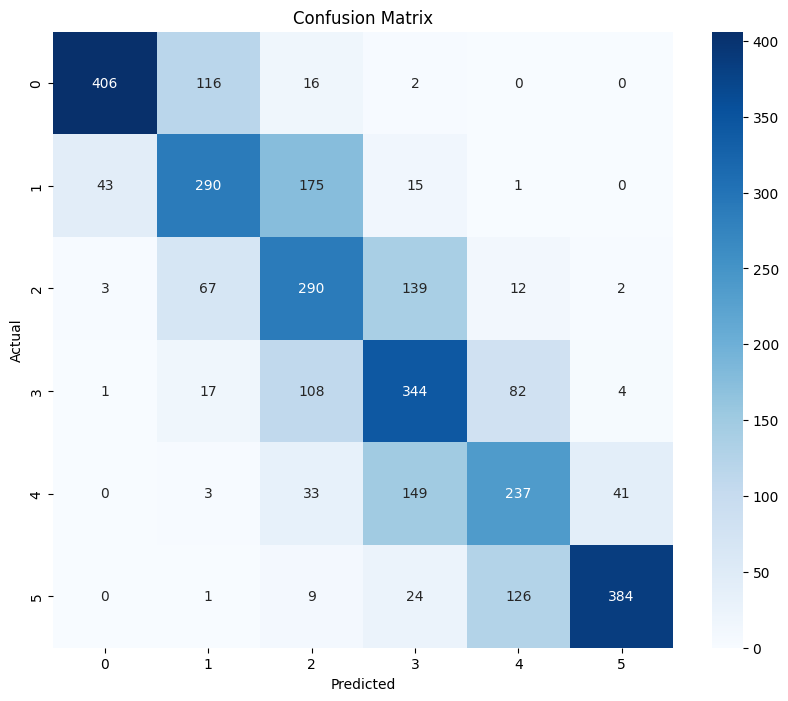

In [20]:
# Evaluate the model

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy test: {accuracy:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [21]:
# Make sure to use the full training set.
X_test_clean = X_test_clean[
    X_clean.columns
]  # Align columns with the training set
y_pred_test = np.clip(np.round(model.predict(X_test_clean)), 0, 5)

# for id,y_pred in zip(ID_test,y_pred_test):
#     print(str(id)+","+str(int(y_pred)))

df_output = pd.DataFrame({"id": ID_test, "price": y_pred_test})

# Convert y_pred to integers
df_output["price"] = df_output["price"].astype(int)

# Specify the file path
file_path = "data/my_preds_subsample_off.csv"

# Write the DataFrame to a CSV file
df_output.to_csv(file_path, index=False)

In [22]:
# make them all numbers for NN
# Step 1: Handle missing values and encode categorical variables
def preprocess_data(X):
    # Fill missing values for numerical columns
    for col in X.select_dtypes(include=["float64", "int64"]).columns:
        X[col] = X[col].fillna(X[col].mean())  # Use mean imputation
    for col in X.select_dtypes(include=["bool"]).columns:
        X[col] = X[col].fillna(False)  # Replace missing values with False
    boolean_columns = X.select_dtypes(include=["bool"]).columns
    X[boolean_columns] = X[boolean_columns].astype(int)
    # Standardize numerical features as
    scaler = StandardScaler()
    X[X.select_dtypes(include=["float64", "int64"]).columns] = (
        scaler.fit_transform(
            X[X.select_dtypes(include=["float64", "int64"]).columns]
        )
    )
    return X


X_clean2 = preprocess_data(X_clean)

In [23]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Step 1: Feature Selection
selector = SelectKBest(score_func=f_regression, k=900)
selector.fit(X_clean2, y)
selected_features = X_clean2.columns[selector.get_support()]
X_selected = X_clean2[selected_features]

# Step 2: Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)


# Step 3: Create a Dataset (unchanged)
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = TabularDataset(X_train_tensor, y_train_tensor)
val_dataset = TabularDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=200, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=200, shuffle=False
)


# Step 4: Define the Neural Network
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 6),
            nn.ReLU(),
            nn.BatchNorm1d(6),
            nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.network(x)


model = RegressionModel(input_dim=X_train.shape[1])

# Step 5: Train the Model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)


def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        print(
            f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        scheduler.step(val_loss)

        if optimizer.param_groups[0]["lr"] < 1e-6:
            print("Learning rate too small. Stopping training.")
            break


train_model(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Train Loss: 3.8296, Val Loss: 0.9990
Epoch 2/100 - Train Loss: 0.9363, Val Loss: 0.8458
Epoch 3/100 - Train Loss: 0.8029, Val Loss: 0.8463
Epoch 4/100 - Train Loss: 0.7475, Val Loss: 0.8338
Epoch 5/100 - Train Loss: 0.6732, Val Loss: 0.8037
Epoch 6/100 - Train Loss: 0.6312, Val Loss: 0.7701
Epoch 7/100 - Train Loss: 0.5922, Val Loss: 0.7858
Epoch 8/100 - Train Loss: 0.5676, Val Loss: 0.7785
Epoch 9/100 - Train Loss: 0.5383, Val Loss: 0.7490
Epoch 10/100 - Train Loss: 0.5128, Val Loss: 0.7315
Epoch 11/100 - Train Loss: 0.4966, Val Loss: 0.7381
Epoch 12/100 - Train Loss: 0.4915, Val Loss: 0.8396
Epoch 13/100 - Train Loss: 0.4723, Val Loss: 0.7338
Epoch 14/100 - Train Loss: 0.4460, Val Loss: 0.7202
Epoch 15/100 - Train Loss: 0.4357, Val Loss: 0.7205
Epoch 16/100 - Train Loss: 0.4242, Val Loss: 0.7436
Epoch 17/100 - Train Loss: 0.4167, Val Loss: 0.7408
Epoch 18/100 - Train Loss: 0.4027, Val Loss: 0.7357
Epoch 19/100 - Train Loss: 0.3661, Val Loss: 0.7014
Epoch 20/100 - Train 

In [24]:
# Predictions on validation set
y_pred = y_pred_bounded = np.clip(
    np.round(model(X_val_tensor).detach().numpy()), 0, 5
)

# Calculate accuracy and RMSE on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy on validation set:", accuracy)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Root Mean Squared Error on validation set:", rmse)

# Predictions on training set
y_pred_train = np.clip(np.round(model(X_train_tensor).detach().numpy()), 0, 5)

# Calculate accuracy and RMSE on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {train_accuracy:.4f}")

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Root Mean Squared Error on training set:", train_rmse)

Accuracy on validation set: 0.5471337579617834
Root Mean Squared Error on validation set: 0.8575256955166636
Accuracy on training set: 0.8607
Root Mean Squared Error on training set: 0.3852984842296496


Accuracy test: 0.5471


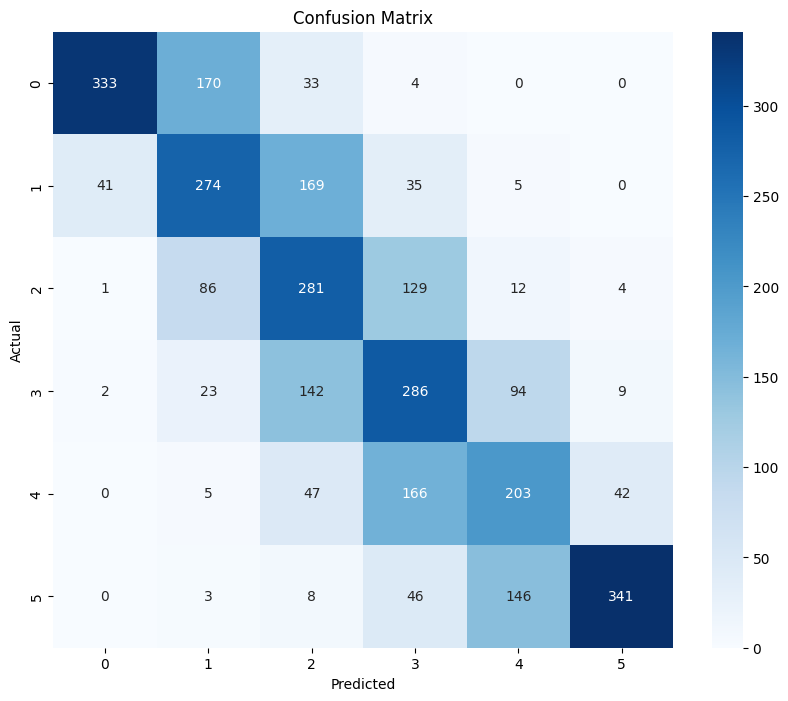

In [25]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy test: {accuracy:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()